In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
import collections
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [9]:
data = pd.read_csv("../data/preprocessed_data/Opportunity_Imu_82_50.csv")
data.drop(["Sensor", "ID", "DTS", ], axis=1, inplace=True)

subjects = data["Subject"]

data.drop("Subject", axis=1, inplace=True)

Y = data["Activity"]

data.drop("Activity", axis=1, inplace=True)

X = data[data.columns.to_list()]

X.head()

,max_Acctr_tChest_X(m/s2),max_Acctr_tChest_Y(m/s2),max_Acctr_tChest_Z(m/s2),max_Acctr_tLA_X(m/s2),max_Acctr_tLA_Y(m/s2),max_Acctr_tLA_Z(m/s2),max_Acctr_tRLA_X(m/s2),max_Acctr_tRLA_Y(m/s2),max_Acctr_tRLA_Z(m/s2),max_Gype_tChest_X(deg/s),...,var_MgFld_tChest_Y(G),var_MgFld_tChest_Y(T),var_MgFld_tChest_Z(G),var_MgFld_tChest_Z(T),var_MgFld_tRLA_X(G),var_MgFld_tRLA_X(T),var_MgFld_tRLA_Y(G),var_MgFld_tRLA_Y(T),var_MgFld_tRLA_Z(G),var_MgFld_tRLA_Z(T)
0,-4.4100,2.2540,9.4570,10.7016,4.1062,-2.8714,-6.3994,5.6938,9.3492,0.774,...,0.008802,8.801513e-11,0.016345,1.634457e-10,0.043094,4.309443e-10,0.021108,2.110787e-10,0.026912,2.691170e-10
1,-4.8510,5.5958,8.0948,12.4950,12.4166,0.6468,-1.3916,2.8028,12.1128,0.774,...,0.027142,2.714235e-10,0.051555,5.155473e-10,0.125925,1.259249e-09,0.007779,7.779297e-11,0.021999,2.199943e-10
2,-3.8122,9.0944,5.2626,17.2676,12.4166,1.1564,3.3712,7.4480,13.3084,0.742,...,0.019204,1.920387e-10,0.038985,3.898528e-10,0.296949,2.969486e-09,0.086473,8.647293e-10,0.110645,1.106446e-09
3,-2.9596,10.5546,5.2626,17.2676,4.5864,1.1564,3.3712,7.4480,13.3084,1.906,...,0.005994,5.994011e-11,0.049770,4.977046e-10,0.234246,2.342456e-09,0.051632,5.163191e-10,0.017615,1.761485e-10
4,-2.7538,10.5546,4.0670,12.1128,4.5864,-1.0976,2.2736,4.8118,12.3088,1.906,...,0.008396,8.395555e-11,0.036326,3.632587e-10,0.317392,3.173920e-09,0.150324,1.503239e-09,0.009386,9.386079e-11


In [10]:
x, X_test, y , y_test = train_test_split(X,Y,test_size=0.15,random_state=0)

In [11]:
n_estimators = 35
n_repeats = 30
k_folds = 10

rf = np.zeros(n_estimators-4)
rf_acc = np.zeros(n_estimators-4)
rf_f1_micro = np.zeros(n_estimators-4)
rf_f1_macro = np.zeros(n_estimators-4)
rf_f1_weighted = np.zeros(n_estimators-4)

count = 1
for i in range (5, n_estimators + 1):
    rf[count-1] = i
    
    print("RF",i)

    cv = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=0)
    
    model = RandomForestClassifier(n_estimators=i, max_depth=9)
    
    scoring = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']
    
    scores = cross_validate(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    rf_acc[count - 1] = scores['test_accuracy'].mean()
    rf_f1_micro[count - 1] = scores['test_f1_micro'].mean()
    rf_f1_macro[count - 1] = scores['test_f1_macro'].mean()
    rf_f1_weighted[count - 1] = scores['test_f1_weighted'].mean()
    
    count = count + 1

metrics_df = pd.DataFrame({
    'n_estimators': rf,
    'accuracy': rf_acc,
    'f1_micro': rf_f1_micro,
    'f1_macro': rf_f1_macro,
    'f1_weighted': rf_f1_weighted
}) 

metrics_df.to_csv("D:/Estudios/Tesis/resultados/OPTYIMU_82_50/rf_metrics_5-35.csv", index=False)

RF 5
RF 6
RF 7
RF 8
RF 9
RF 10
RF 11
RF 12
RF 13
RF 14
RF 15
RF 16
RF 17
RF 18
RF 19
RF 20
RF 21
RF 22
RF 23
RF 24
RF 25
RF 26
RF 27
RF 28
RF 29
RF 30
RF 31
RF 32
RF 33
RF 34
RF 35


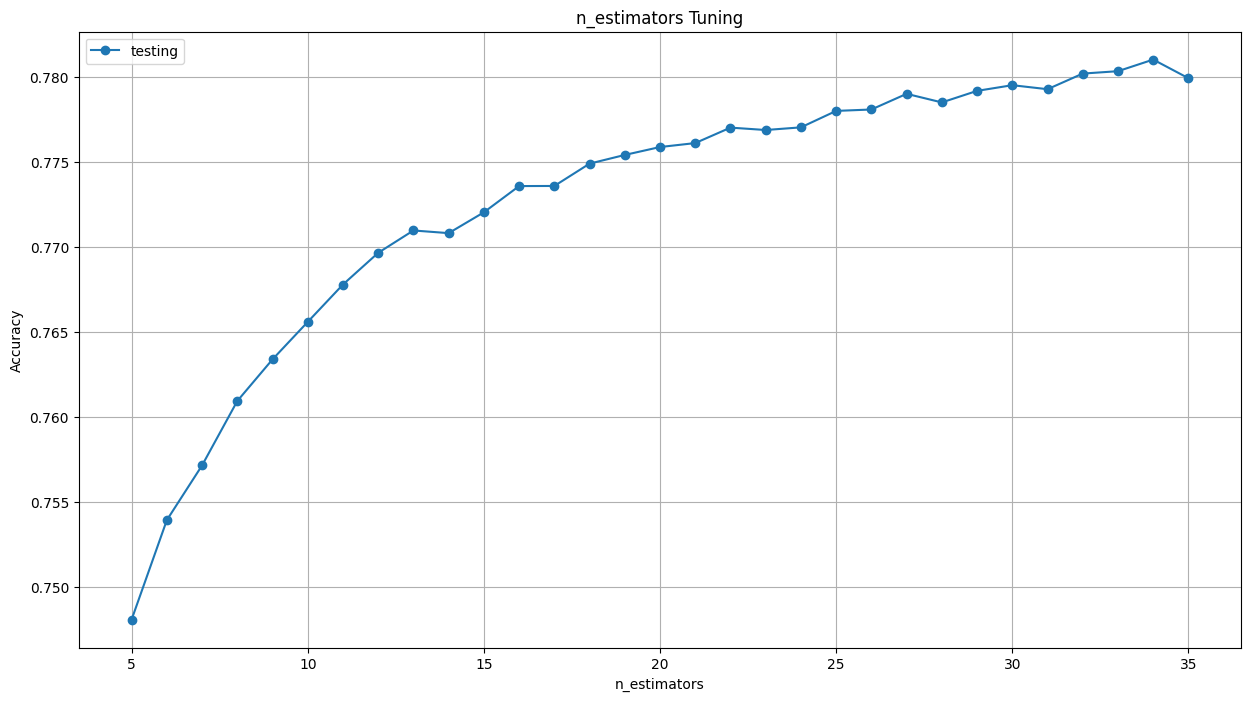

13.0


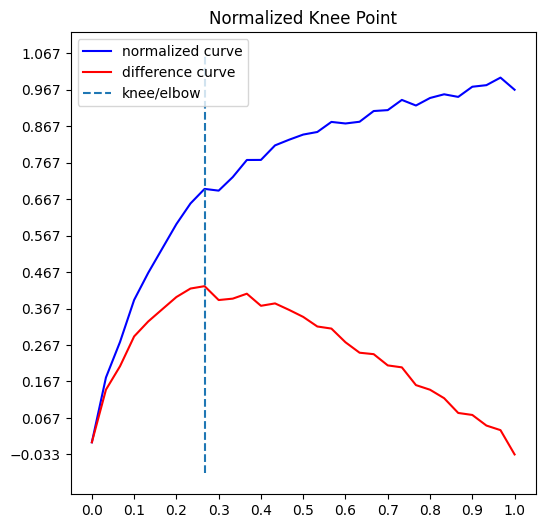

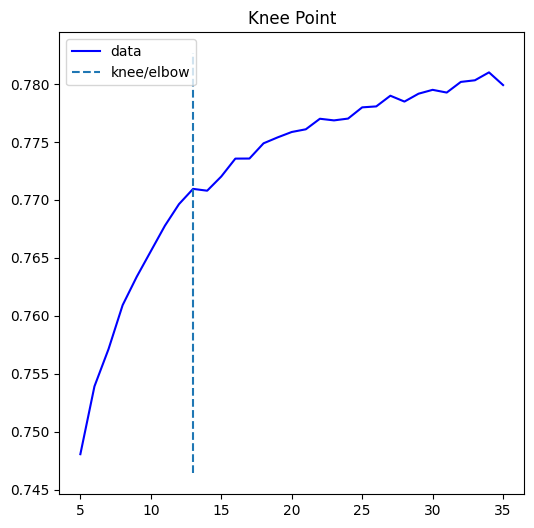

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(rf, rf_acc, '-o', label="testing")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid()
plt.title("n_estimators Tuning")
plt.show()

kneedle = KneeLocator(rf.tolist(), rf_acc.tolist(), S=1.0, curve="concave", direction="increasing")

print(round(kneedle.knee, 3))
kneedle.plot_knee_normalized()
kneedle.plot_knee()

In [13]:
model = RandomForestClassifier(n_estimators=13, max_depth=9)
model.fit(x, y)  

y_train_hat = model.predict(x)
y_test_hat = model.predict(X_test)

#print(metrics.accuracy_score(y_test,y_test_hat))
print(metrics.confusion_matrix(y_test, y_test_hat))
#print(metrics.f1_score(y_test, y_test_hat, average=None))
print(metrics.classification_report(y_test, y_test_hat))

[[135   0   4   5   5]
 [  0 194  30  33  46]
 [  0  13 447  25  12]
 [  0  15  31 197  61]
 [  0  41  33  83 511]]
              precision    recall  f1-score   support

   OPTY_A_01       1.00      0.91      0.95       149
   OPTY_A_02       0.74      0.64      0.69       303
   OPTY_A_03       0.82      0.90      0.86       497
   OPTY_A_04       0.57      0.65      0.61       304
   OPTY_A_05       0.80      0.76      0.78       668

    accuracy                           0.77      1921
   macro avg       0.79      0.77      0.78      1921
weighted avg       0.78      0.77      0.77      1921


In [14]:
feature_names = X.columns

feature_importances = model.feature_importances_

feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importances_df_sorted = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df_sorted)

feature_importances_df_sorted.to_csv("D:/Estudios/Tesis/resultados/OPTYIMU_82_50/rf_importance_13_9.csv", index=False)

                       Feature  Importance
16       max_MgFld_tChest_X(T)    0.049612
69    median_MgFld_tChest_X(G)    0.040907
103        min_MgFld_tRLA_X(T)    0.035285
112    rango_Acctr_tLA_Y(m/s2)    0.033386
60   median_Acctr_tRLA_X(m/s2)    0.030725
..                         ...         ...
178      var_MgFld_tChest_X(T)    0.000000
182      var_MgFld_tChest_Z(T)    0.000000
184        var_MgFld_tRLA_X(T)    0.000000
186        var_MgFld_tRLA_Y(T)    0.000000
188        var_MgFld_tRLA_Z(T)    0.000000

[189 rows x 2 columns]


In [15]:
acum_trans = collections.defaultdict(float)
acum_disp = collections.defaultdict(float)
acum_pos = collections.defaultdict(float)

for _, row in feature_importances_df.iterrows():
    feature = row["Feature"]
    importance = row["Importance"]
    trans, disp, pos = feature.split("_", 2)
    acum_trans[trans] += importance
    acum_disp[disp] += importance
    pos = pos.rsplit("_", 1)[0] 
    acum_pos[pos] += importance

lista_acum_trans = list(acum_trans.items())
lista_acum_disp = list(acum_disp.items())
lista_acum_pos = list(acum_pos.items())

df_acum_trans = pd.DataFrame(lista_acum_trans, columns=["Transformación", "Acumulado"])
df_acum_disp = pd.DataFrame(lista_acum_disp, columns=["Dispositivo", "Acumulado"])
df_acum_pos = pd.DataFrame(lista_acum_pos, columns=["Posición", "Acumulado"])

df_acum_trans.to_csv("D:/Estudios/Tesis/resultados/OPTYIMU_82_50/rf_acum_trans_13_9.csv", index=False)
df_acum_disp.to_csv("D:/Estudios/Tesis/resultados/OPTYIMU_82_50/rf_acum_disp_13_9.csv", index=False)
df_acum_pos.to_csv("D:/Estudios/Tesis/resultados/OPTYIMU_82_50/rf_acum_pos_13_9.csv", index=False)